In [1]:
import fiona
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from time import time
from tqdm import tqdm
import xarray as xr
import torch
import torch.nn as nn
import matplotlib.colors as colors
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

seed = 1234
np.random.seed(seed)

## 1. Read Xarray Files


In [2]:
def get_filenames(directory):
    filenames = sorted(os.listdir(directory))
    return [f for f in filenames if f.endswith(".nc")]


def get_path(directory, filename):
    return os.path.join(directory, filename)


def get_basename(path):
    return os.path.basename(path)


def get_month_year(file_name, dtype="ppt"):
    """Get month and year from file name"""
    if dtype == "ppt":
        time = pd.Timestamp("-".join(file_name.split(".")[0].split("_")[1:]))
        month, year = time.month, time.year
    elif dtype == "sst":
        year, month = file_name.split(".")[-2][-6:-2], file_name.split(".")[-2][-2:]
        month, year = int(month), int(year)
    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")
        month, year = None, None
    return month, year


def read_xr(path, dtype="ppt"):
    """Read xarray file"""
    file_data = xr.load_dataset(path, engine="netcdf4")
    file_name = get_basename(path)
    month, year = get_month_year(file_name, dtype)
    xr_data = [file_name, year, month]

    if dtype == "ppt":
        file_data = file_data.rename_vars(
            {list(file_data.keys())[1]: "ppt", "longitude": "lon", "latitude": "lat"}
        )

        # Coarsen data to reduce resolution
        file_data = file_data.coarsen(latitude=4, longitude=4, boundary="trim").mean()
        #         file_data = file_data.sel(longitude=slice(-300, -100))

        ##Slice for west coast
        file_data = file_data.sel(longitude=slice(0, 150))

        xr_data.append(file_data.ppt.values)
        columns = list("FYMD")
        columns[-1] = "ppt"

    elif dtype == "sst":
        # Coarsen data to reduce resolution
        #         file_data = file_data.coarsen(lat = 4, lon = 4, boundary = "trim").mean()

        ##Slice for west coast
        #         file_data = file_data.sel(lon=slice(100, 400))

        xr_data.extend([file_data.sst.values, file_data.ssta.values])
        columns = list("FYMDA")
        columns[-2], columns[-1] = "sst", "ssta"

    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")

    longitude, latitude = file_data.lon.values, file_data.lat.values
    return xr_data, longitude, latitude, columns


def load_data(directory, dtype="ppt"):
    """Load directory files in a pandas dataframe"""
    filenames = get_filenames(directory)
    data_info_list = []
    for i, file_name in tqdm(enumerate(filenames)):
        path = get_path(directory, file_name)
        xr_data, longitude, latitude, columns = read_xr(path, dtype)
        data_info_list.append(xr_data)
    df = pd.DataFrame([p for p in data_info_list], columns=columns)
    return df, latitude, longitude

#### `Change ppt_directory and sst_directory based on your directories`


In [3]:
ppt_directory = "data/ppt-nc-1895-2020"
sst_directory = "data/ERSST"

In [4]:
### Load ppt data
ppt_df, lat, lon = load_data(ppt_directory, dtype="ppt")

759it [00:20, 36.38it/s]


### PPT Levels in different U.S. States


In [5]:
def show_states(west_coast=True, state_file="States/cb_2018_us_state_20m.shp"):
    shape = fiona.open(state_file)
    for s in shape:
        pts = s["geometry"]["coordinates"]
        for p in pts:
            state = np.array(p).squeeze()
            if state[:, 1].min() < 50 and state[:, 1].min() > 22:
                if not west_coast:
                    plt.plot(state[:, 0], state[:, 1], color="black")
                elif np.max(state[:, 0]) < -100:  # plot only west coast
                    plt.plot(state[:, 0], state[:, 1], color="black")

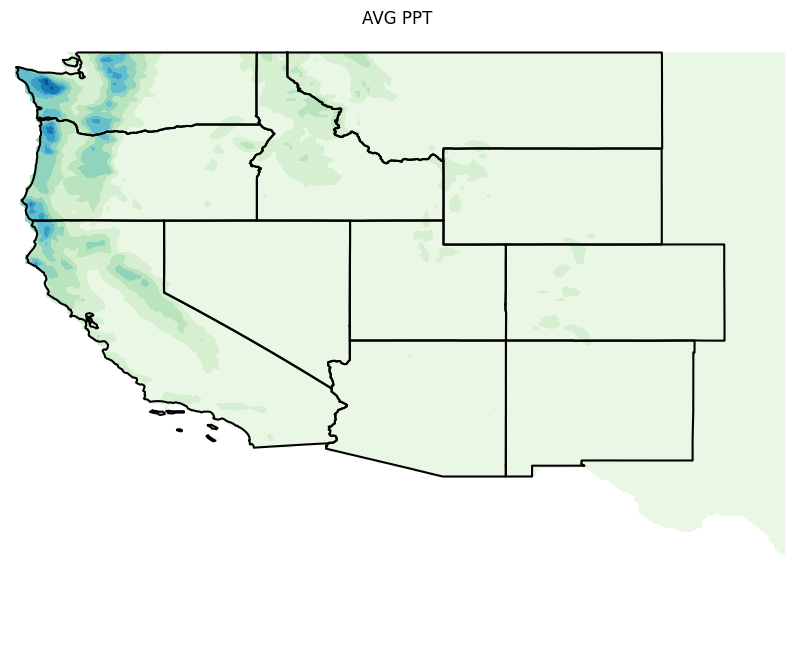

In [6]:
avg_ppt = ppt_df["ppt"].mean()

plt.figure(figsize=(10, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, avg_ppt, cmap="GnBu")
show_states()
plt.axis("off")
plt.title("AVG PPT")
plt.show()
plt.close()

In [7]:
### Load sst data
sst_df, _, _ = load_data(sst_directory, dtype="sst")
sst_df

1644it [00:20, 79.01it/s] 


,F,Y,M,sst,ssta
0,ersst.v5.188001.nc,1880,1,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1,ersst.v5.188002.nc,1880,2,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
2,ersst.v5.188003.nc,1880,3,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
3,ersst.v5.188004.nc,1880,4,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
4,ersst.v5.188005.nc,1880,5,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
...,...,...,...,...,...
1639,ersst.v5.201608.nc,2016,8,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1640,ersst.v5.201609.nc,2016,9,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1641,ersst.v5.201610.nc,2016,10,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1642,ersst.v5.201611.nc,2016,11,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...


### SST Levels


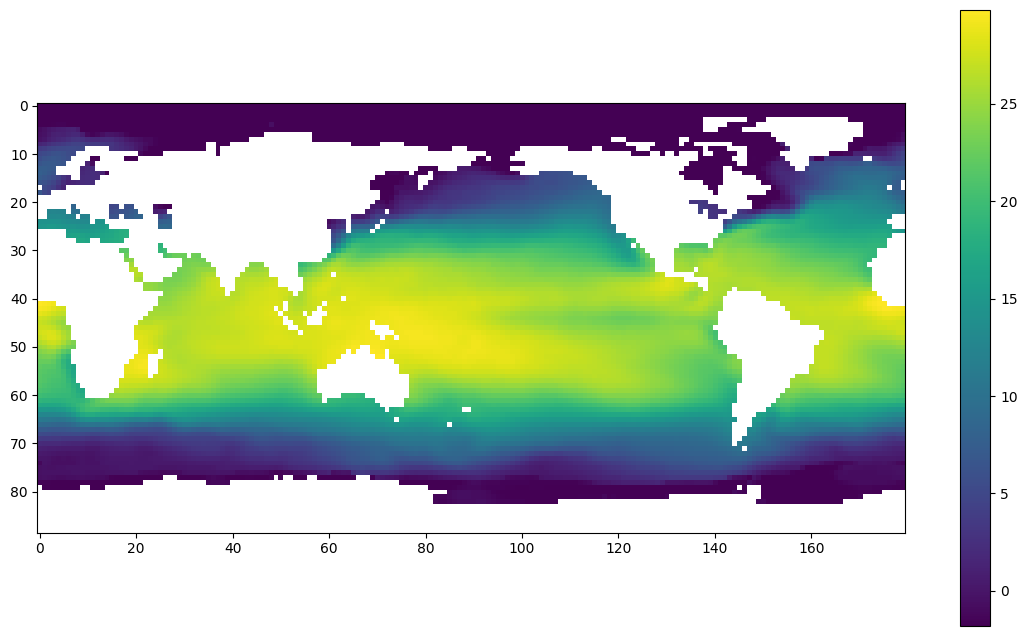

(1644,)

In [8]:
plt.figure(figsize=(14, 8))
sst_example = sst_df["sst"].iloc[0]
plt.imshow(np.flipud(sst_example.reshape(sst_example.shape[-2], sst_example.shape[-1])))
plt.colorbar()
plt.show()
sst_df["sst"].shape

In [9]:
## Check shapes of ppt and sst
sst_df["sst"].iloc[0].shape, ppt_df["ppt"].iloc[0].shape

((1, 1, 89, 180), (155, 150))

In [10]:
# get rainfall month and year
rain_row = ppt_df.iloc[0]
m, y = rain_row["M"], rain_row["Y"]

# get sst month and year
sst_row = sst_df[(sst_df["M"] == m) & (sst_df["Y"] == y)]  # bitmask filters for month and year
index_position = sst_row.index[0]  # index returns Index object, so we need to get the first element

# if index_position < 24:
#     # do something, though this should never happen cuz sst starts far earlier

prev24 = sst_df.iloc[index_position - 24 : index_position]

In [11]:
import pandas as pd

# Sample DataFrame
data = {
    "month": [1, 5, 7, 5, 12],
    "year": [2020, 2021, 2021, 2022, 2020],
    "data": ["A", "B", "C", "D", "E"],  # Additional data column for illustration
}
df = pd.DataFrame(data)

# Your target month and year
target_month = 5
target_year = 2021

# Create a boolean mask to filter the DataFrame
mask = (df["month"] == target_month) & (df["year"] == target_year)

# Apply the mask to the DataFrame
filtered_df = df[mask]

# Display the filtered DataFrame
print(filtered_df)

   month  year data
1      5  2021    B


## 2. Combine SST and PPT


In [12]:
df = sst_df.merge(ppt_df, on=["Y", "M"], suffixes=("_sst", "_ppt"), how="inner")

## 3. Add Temporal Features


In [13]:
def add_time(df):
    """Add Time Column"""
    min_year = np.min(df["Y"])
    df["T"] = (df["Y"] - min_year) * 12 + df["M"]
    return df


def add_season(df):
    """adds Season Column (0 for months 1,2,3 and 1 for months 10,11,12)"""
    df["season"] = ((df["M"] - 1) // 4).astype(bool).astype(int)
    return df


df = add_season(add_time(df))
df.to_csv("data/df.csv", index=False)

### ppt has data for only months 1,2,3,10,11,12. While sst has all months.


## 4. Add Clusters


In [14]:
clusters = np.load("clusters.npy")

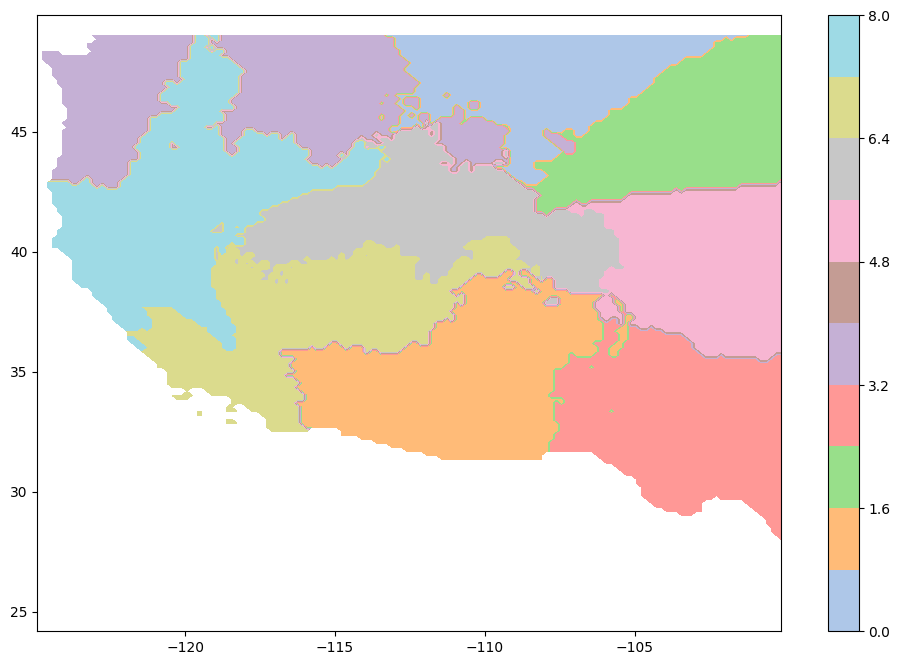

np.unique(clusters):  [ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]


In [15]:
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.show()
print("np.unique(clusters): ", np.unique(clusters))

In [16]:
def average_clusters(image, cluster_array, return_image=True):
    """Average the values of each cluster in the image"""
    unique_clusters = np.unique(cluster_array)  # Find unique cluster labels

    if return_image:
        # Initialize an array to store the average values
        averaged_image = np.zeros_like(image, dtype=float)
    else:
        cluster_averages = []

    for cluster_label in unique_clusters:
        # Mask the original image with the current cluster label
        masked_image = np.where(cluster_array == cluster_label, image, 0)

        # Calculate the average value for the current cluster
        cluster_size = np.sum(cluster_array == cluster_label)
        cluster_average = np.sum(masked_image) / cluster_size

        if return_image:
            # Replace pixels in the averaged image with the cluster average
            averaged_image += np.where(
                cluster_array == cluster_label, cluster_average, 0
            )
        else:
            cluster_averages.append(cluster_average)

    return averaged_image if return_image else np.array(cluster_averages)


avg_clusters = average_clusters(df.iloc[0].ppt, clusters)
avg_clusters

/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_29671/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

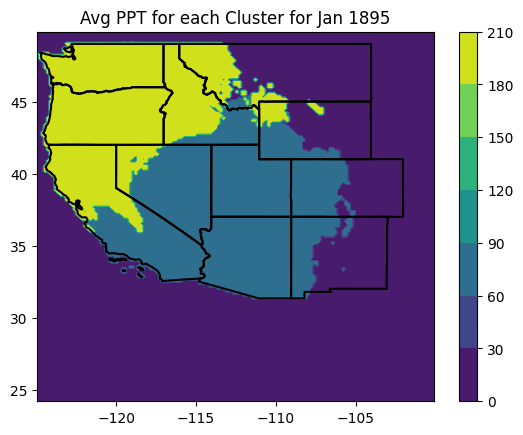

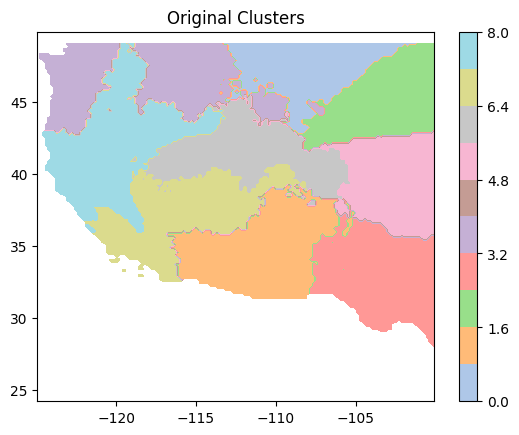

In [17]:
plt.contourf(xx, yy, avg_clusters)
plt.colorbar()
show_states()
plt.title("Avg PPT for each Cluster for Jan 1895")
plt.show()

xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.title("Original Clusters")
plt.show()

In [18]:
df["ppt_cluster"] = df["ppt"].apply(lambda x: average_clusters(x, clusters))
df["ppt_cluster_vector"] = df["ppt"].apply(
    lambda x: average_clusters(x, clusters, return_image=False)[:-1]
)

/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_29671/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size
/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_29671/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


## 5. Add Quantiles


In [19]:
def get_quantiles(df, cluster=True):

    vector = df.ppt_cluster_vector if cluster else df.ppt

    ppt_vector = np.stack(vector.apply(lambda x: x.reshape(-1))).T
    q1 = np.quantile(ppt_vector, 0.25, axis=1, keepdims=True).flatten()
    q2 = np.quantile(ppt_vector, 0.5, axis=1, keepdims=True).flatten()
    q3 = np.quantile(ppt_vector, 0.75, axis=1, keepdims=True).flatten()
    return q1, q2, q3


q1, q2, q3 = get_quantiles(df)
q1

array([ 9.5338221 , 12.17312131,  9.24412442,  7.47316639, 94.40965887,
        8.27551748, 25.58297759, 13.8765325 , 42.52929087])

In [20]:
def get_quantized(x, q1, q2, q3):
    output = np.zeros_like(x)
    output[x <= q1] = 1
    q2_arr = np.array(x > q1) * np.array(x <= q2)
    q3_arr = np.array(x > q2) * np.array(x <= q3)
    output[q2_arr] = 2
    output[q3_arr] = 3
    output[x > q3] = 4
    return output

In [21]:
df["ppt_cluster_vector_quantized"] = df["ppt_cluster_vector"].apply(
    lambda x: get_quantized(x, q1, q2, q3)
)
df[["T", "M", "ppt_cluster_vector_quantized"]]

,T,M,ppt_cluster_vector_quantized
0,1,1,"[4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0]"
1,2,2,"[3.0, 3.0, 3.0, 4.0, 1.0, 4.0, 2.0, 3.0, 2.0]"
2,3,3,"[2.0, 1.0, 3.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0]"
3,10,10,"[1.0, 3.0, 1.0, 4.0, 1.0, 3.0, 1.0, 1.0, 1.0]"
4,11,11,"[4.0, 4.0, 4.0, 4.0, 2.0, 3.0, 3.0, 2.0, 1.0]"
...,...,...,...
727,1454,2,"[1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 1.0]"
728,1455,3,"[3.0, 1.0, 4.0, 2.0, 4.0, 4.0, 4.0, 3.0, 4.0]"
729,1462,10,"[4.0, 1.0, 4.0, 2.0, 4.0, 2.0, 4.0, 2.0, 4.0]"
730,1463,11,"[2.0, 3.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0]"


## Organizing Data into y_labels and x_input

Want to create a dataframe of sea surface temperature input for each cluster precipitation estimation (1, 2, 3, or 4).
The input data should be 24 months worth of sea surface temperature data. This data is stored in a quadruple vector.
For each a ppt_cluster_vector quantity, grab the last 24 months of "sst" quadruple vector data information.
to test.


### Organizing Y Labels and processing ppt clusters


In [22]:
y_labels = df.loc[:,["Y", "M", "ppt_cluster_vector_quantized"]]
y_labels = y_labels.rename(columns={"M": "month", "Y": "year"})
y_labels["date"] = pd.to_datetime(y_labels[["month","year"]].assign(day=1))
y_labels["date"] = y_labels['date']

y_labels.drop(["month"], axis=1, inplace=True)
y_labels.drop(["year"], axis=1, inplace=True)
y_labels.set_index("date", inplace=True)

ppt_data = np.array(y_labels["ppt_cluster_vector_quantized"]) - 1
# get all 9 clusters in a list, where each cluster is the ith column in ppt_data
clusters = [np.array([x[i] for x in ppt_data]) for i in range(len(ppt_data[0]))]
clusters = np.array(clusters)

In [23]:
sst_condensed = sst_df.loc[:,["Y", "M", "sst"]]
sst_condensed = sst_condensed.rename(columns={"M": "month", "Y": "year"})
sst_condensed["date"] = pd.to_datetime(sst_condensed[["month","year"]].assign(day=1))
sst_condensed["date"] = sst_condensed['date']

sst_condensed.drop(["month"], axis=1, inplace=True)
sst_condensed.drop(["year"], axis=1, inplace=True)
sst_condensed.set_index("date", inplace=True)

### Process sst data for forest tree classification on entire dataset


In [24]:
x_input_rows = []
for date in y_labels.index:
    start_date = date - pd.DateOffset(months=23)
    end_date = date
    sst_in_range = np.array(sst_condensed.loc[start_date:end_date, 'sst'].tolist()) # shape here is (24, 1, 1, 89, 180)
    IO_TP_sst_in_range = sst_in_range.flatten() #1 x 384480
    sst_in_range = sst_in_range[~np.isnan(sst_in_range)] # 263712
    
    x_input_rows.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

x_input = pd.DataFrame(x_input_rows)
x_input["start date"] = x_input["start date"].dt.to_period('M')
x_input["end date"] = x_input["end date"].dt.to_period('M')
sst_data_all = np.array([xi.tolist() for xi in np.array(x_input[:]["sst rows"])])

### Check if y labels are distributed


In [74]:
# put all data from y_labels into a single, one-dimensional array
ppt_data_all = np.array(y_labels["ppt_cluster_vector_quantized"]) - 1
ppt_data_all = np.array([[y for y in x] for x in ppt_data_all])
ppt_data_all.reshape(1, -1)
# count the number of times each label appears in the data
unique, counts = np.unique(ppt_data_all, return_counts=True)
d = dict(zip(unique, counts))
d

{0.0: 1647, 1.0: 1647, 2.0: 1647, 3.0: 1647}

### Process data for PCA pre-processing with regions

We need to split the data into the following regions, so we use array slicing

![](PCA_regions.png)

Now that we have the regions, we'll split the sst data into regions using these approximate coordinates we have estimated. Once the data is separated into regions, we can use principal component analysis to reduce dimensionality and assess the effect on random forest training quality.


In [25]:
sst_squeezed = np.array([sst_condensed["sst"].iloc[row].squeeze((0,1)) for row in range(len(sst_condensed))])
pca = PCA(n_components=2)

def split_and_pca(x_start, x_end, y_start, y_end):
    """Slice the SST data according to the region boundaries and perform PCA"""
    region = sst_squeezed[:, y_start:y_end, x_start:x_end] # slice according to region boundaries
    region = region.reshape(sst_squeezed.shape[0], -1) # flatten SST data into one dimension
    mean = np.nanmean(region) # need the mean to fill in nan values
    region = np.nan_to_num(region, copy=False, nan=mean) # replace nan with mean
    region = pca.fit_transform(region) # perform PCA
    return region

# IO -> data[34:55][10:67]
# TP -> data[34:55][55:143]
# NP -> data[11:32][59:128]
# WP -> data[28:49][55:84]

TP = split_and_pca(55, 144, 34, 56)
IO = split_and_pca(10, 68, 34, 56)
WP = split_and_pca(55, 85, 28, 50)
NP = split_and_pca(59, 129, 11, 33)

sst_data_all_pca = np.concatenate((TP, IO, WP, NP), axis=1)
# put back in original dataframe format
sst_condensed_pca = sst_condensed.copy()
for row in range(len(sst_condensed_pca)):
    sst_condensed_pca["sst"].iloc[row] = sst_data_all_pca[row]

sst_condensed_pca["sst"].iloc[0].shape

(8,)

Now we have to create chunks of 24 preceding months to correspond to each y label month (since we are predicting one month's ppt data based on the preceding 24 months of sst data)


In [26]:
def chunk_sst_to_label(pca_data):
    """
    Take SST data (preprocessed by PCA on each region), type is a DataFrame organized by date
    Return 732 x num_features numpy array, where each row is the 24 months of SST data (reduced to some number of dimensions by PCA) preceding the y label date
    """
    sst_24_months = []

    for date in y_labels.index:
        start_date = date - pd.DateOffset(months=23)
        end_date = date
        # get 24 months of pca sst data preceding the y label date
        sst_in_range = np.array(pca_data.loc[start_date:end_date, 'sst'].tolist()).flatten()
        # append to the list of rows
        sst_24_months.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

    # convert to DataFrame
    sst_24_months = pd.DataFrame(sst_24_months)
    # convert dates to period
    sst_24_months["start date"] = sst_24_months["start date"].dt.to_period('M')
    sst_24_months["end date"] = sst_24_months["end date"].dt.to_period('M')
    # convert to final raw numpy array with only the sst data
    sst_24_months = np.array([xi.tolist() for xi in np.array(sst_24_months[:]["sst rows"])])
    print(f"sst_24_months shape: {sst_24_months.shape}")
    
    return sst_24_months

sst_pca = chunk_sst_to_label(sst_condensed_pca)

sst_24_months shape: (732, 192)


In [27]:
def get_cluster_data(ind):
    X_train, X_test, y_train, y_test = train_test_split(sst_data_all, clusters[ind], test_size=0.1, random_state=4)
    return X_train, X_test, y_train, y_test

## Training a Random Forest

We now have our nine label clusters and our input rows as well (which contain the flattened sea surface temperature data across the globe, excluding land coordinates). We'd like to train a random forest model on these as the first iteration of trying to fit a model.


In [29]:
trials = []
conf_preds = []
conf_labels = []
for trial in range(5):
    accuracies = []
    for i in range(len(clusters)):
        X_train, X_test, y_train, y_test = get_cluster_data(i)

        rf = RandomForestClassifier(max_depth=1, min_samples_leaf=100, n_estimators=200) # since there are only 4 possible outputs, we use a Classifier
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_train)  # changed to X_train to see if confusion matrix still skewed

        accuracies.append(accuracy_score(y_train, y_pred))
        conf_preds.append(y_pred)
        conf_labels.append(y_train)  # changed to y_train to see if confusion matrix still skewed
        print(f"Accuracy for cluster {i}: {accuracies[i]}")
    trials.append(accuracies)

trials = np.array(trials)
# get the mean accuracy for each cluster
mean_accuracies = np.mean(trials, axis=0)
print(f"Mean accuracy for cluster {i}: {mean_accuracies[i]}")
np.savetxt("4_comps.csv", trials, delimiter=",")


Accuracy for cluster 0: 0.3783783783783784
Accuracy for cluster 1: 0.1891891891891892
Accuracy for cluster 2: 0.40540540540540543
Accuracy for cluster 3: 0.40540540540540543
Accuracy for cluster 4: 0.28378378378378377
Accuracy for cluster 5: 0.40540540540540543
Accuracy for cluster 6: 0.25675675675675674
Accuracy for cluster 7: 0.35135135135135137
Accuracy for cluster 8: 0.43243243243243246
Accuracy for cluster 0: 0.3918918918918919
Accuracy for cluster 1: 0.24324324324324326
Accuracy for cluster 2: 0.40540540540540543
Accuracy for cluster 3: 0.4189189189189189
Accuracy for cluster 4: 0.28378378378378377
Accuracy for cluster 5: 0.4189189189189189
Accuracy for cluster 6: 0.25675675675675674
Accuracy for cluster 7: 0.36486486486486486
Accuracy for cluster 8: 0.43243243243243246
Accuracy for cluster 0: 0.3783783783783784
Accuracy for cluster 1: 0.22972972972972974
Accuracy for cluster 2: 0.40540540540540543
Accuracy for cluster 3: 0.40540540540540543
Accuracy for cluster 4: 0.283783783783

### Graphing results


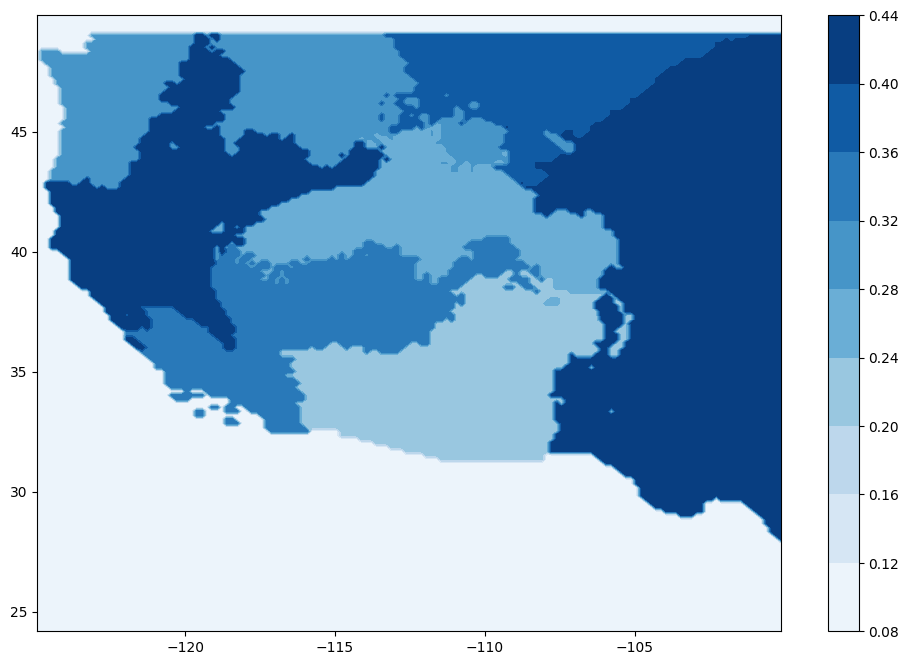

In [30]:
# clusters is 155x150 grid of values 0-8 -> convert to grid of same size with accuracy values

cluster_map_raw = np.load("clusters.npy")
cluster_map = np.where(np.isnan(cluster_map_raw), -1, cluster_map_raw)  # replace NaNs with -1
cluster_map = cluster_map.astype(int) # convert to integer
# replace all cluster numbers with their corresponding accuracy 
cluster_map = mean_accuracies[cluster_map]
cluster_map = np.where(np.isnan(cluster_map_raw), 0.1, cluster_map)  # replace where NaNs originally were with 0
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, cluster_map, levels=10, cmap="Blues")
plt.colorbar()
plt.show()


### Confusion Matrix


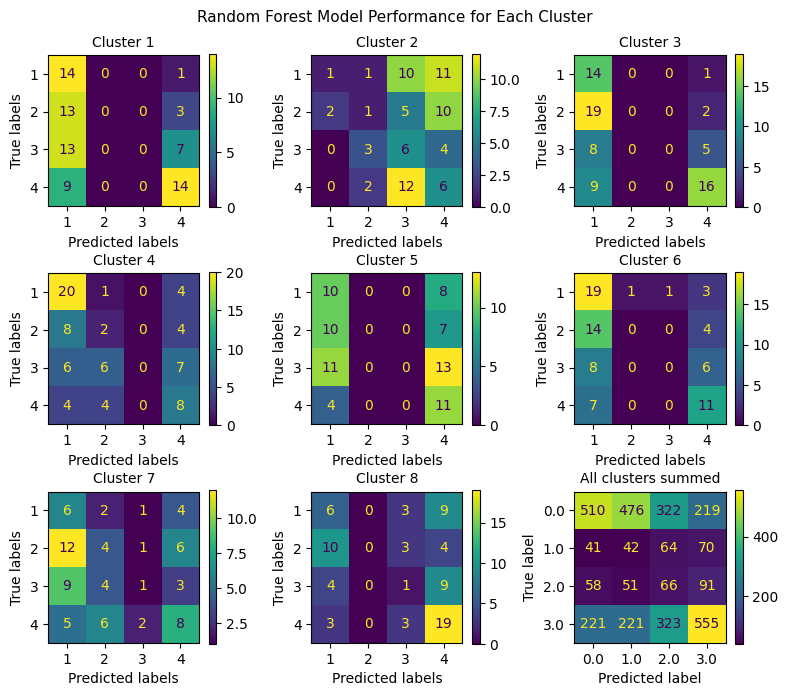

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(predictions, correct_labels, title=""):
    """ Plot the confusion matrices for a model for each cluster
    Args: 
        predictions (list): A list of 8 lists, where the ith list corresponds to the model predictions for cluster i+1.
        correct_labels (list): A list of 8 lists, where the ith list corresponds to the actual labels for cluster i+1
        title (str) (optioanl): A title for the figure
    """
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,7))
    spec = fig.add_gridspec(2, 4)
    flattened_axes = axes.flatten()
    for i in range(8):
        a = flattened_axes[i]
        ConfusionMatrixDisplay.from_predictions([int(x + 1) for x in correct_labels[i]], [int(x + 1) for x in predictions[i]], ax=a)
        a.set_title(label=f'Cluster {i+1}', fontdict={'fontsize':10})
        a.set_xlabel(xlabel='Predicted labels',fontdict={'fontsize':10})
        a.set_ylabel(ylabel='True labels',fontdict={'fontsize':10})
        i += 1
    ConfusionMatrixDisplay.from_predictions(np.array(predictions).flatten(),np.array(correct_labels).flatten(), ax=flattened_axes[8])
    flattened_axes[8].set_title(label="All clusters summed", fontdict={'fontsize':10})
    fig.suptitle(title, fontsize=11)
    plt.tight_layout()  
    plt.show()

plot_confusion_matrices(conf_preds, conf_labels, "Random Forest Model Performance for Each Cluster")

## Testing Hyperparameters

Use GridSearchCV library to test different values for different parameters


In [32]:
# params = {
#     'max_depth': [1,2,3,5,10,20, 50, 100, 150, 200, 500, None],
#     'min_samples_leaf': [1, 5, 10, 20, 50, 100, 200, 500],
#     'n_estimators': [10,25,30,50,100,200]
# }

# # Assuming we have a list of clusters called 'clusters'
# # and a function 'get_cluster_data' that returns X_train and y_train for a given cluster
# best_params = {}

# for i in range(len(clusters)):
#     X_train, _, y_train, _ = get_cluster_data(i)
#     # Instantiate the grid search model
#     grid_search = GridSearchCV(estimator=rf,
#                             param_grid=params,
#                             cv = 4,
#                             n_jobs=-1, verbose=1, scoring="accuracy")

#     grid_search.fit(X_train, y_train)
        
#         # Store the best parameters for the current cluster
#     best_params[i] = grid_search.best_params_
#     best_score = grid_search.best_score_
#     best_esty = grid_search.best_estimator_
#     print(f"best accuracy cluster {i}: {best_score}")
#     print(f"best estimators cluster {i}: {best_esty}")
#     print(f"best params for cluster {i}: {best_params[i]}")


## Trying Neural Network

Creating and training a logistic regression model


#### Model


In [33]:
# change to built in methods
class RainPrediction(nn.Module):
    def __init__(self, num_regions, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.05),
            nn.Linear(num_regions, 20),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(20, num_classes)
        )

    def forward(self, x):
        return self.model(x)
    

#### Training


In [36]:
def gradient_descent(model, loss_func, train_dataset, valid_dataset, optimizer, steps=5000, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    losses = []
    valid_losses = []
    for step in tqdm(range(steps)):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_func(model(x_batch), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        model.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            for x_valid_batch, y_valid_batch in valid_loader:
                valid_loss = loss_func(model(x_valid_batch), y_valid_batch)
                running_valid_loss += valid_loss.item()
        avg_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        if (step + 1) % 10 == 0:
            print(f"Step {step+1}/{steps}, Training Loss: {avg_loss}, Validation Loss: {avg_valid_loss}")

    print(f"Final training loss: {losses[-1]}")
    print(f"Final validation loss: {valid_losses[-1]}")

    return losses, valid_losses


def calculate_accuracy(model, x, y):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        return correct / total, predicted

# Iterate for all 8 clusters
nn_train_predictions_all_clusters = []
nn_test_predictions_all_clusters = []
nn_train_labels_all_clusters = []
nn_test_labels_all_clusters = []

for i in range(8):
    print(f"\nBegin training model for cluster {i+1}")
    # Get data for this cluster
    X_train, X_test, y_train, y_test = get_cluster_data(i)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Initialize the model and optimizer
    model = RainPrediction(X_train.shape[1], 4)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Run the training
    losses, valid_losses = gradient_descent(
        model, nn.CrossEntropyLoss(), train_dataset, test_dataset, optimizer, steps=150
    )

    train_accuracy, nn_train_predictions = calculate_accuracy(model, X_train_tensor, y_train_tensor)
    test_accuracy, nn_test_predictions = calculate_accuracy(model, X_test_tensor, y_test_tensor)

    nn_train_predictions_all_clusters.append(nn_train_predictions.tolist())
    nn_test_predictions_all_clusters.append(nn_test_predictions.tolist())
    nn_train_labels_all_clusters.append(y_train_tensor.tolist())
    nn_test_labels_all_clusters.append(y_test_tensor.tolist())

    print(f"Training accuracy for cluster {i+1}: {train_accuracy * 100}%")
    print(f"Test accuracy for cluster {i+1}: {test_accuracy * 100}%")


Begin training model for cluster 1


  7%|▋         | 10/150 [00:09<02:09,  1.08it/s]

Step 10/150, Training Loss: 1.3984606699510054, Validation Loss: 1.3901496529579163


 13%|█▎        | 20/150 [00:18<01:59,  1.09it/s]

Step 20/150, Training Loss: 1.397743290120905, Validation Loss: 1.388528287410736


 20%|██        | 30/150 [00:27<01:51,  1.08it/s]

Step 30/150, Training Loss: 1.3895214254205877, Validation Loss: 1.3876088857650757


 27%|██▋       | 40/150 [00:37<01:43,  1.07it/s]

Step 40/150, Training Loss: 1.38920766657049, Validation Loss: 1.3876689076423645


 33%|███▎      | 50/150 [00:46<01:34,  1.06it/s]

Step 50/150, Training Loss: 1.3892244750803167, Validation Loss: 1.3876420855522156


 40%|████      | 60/150 [00:55<01:23,  1.08it/s]

Step 60/150, Training Loss: 1.3867859081788496, Validation Loss: 1.3877878189086914


 47%|████▋     | 70/150 [01:05<01:14,  1.08it/s]

Step 70/150, Training Loss: 1.3865305618806318, Validation Loss: 1.3880868554115295


 53%|█████▎    | 80/150 [01:14<01:04,  1.08it/s]

Step 80/150, Training Loss: 1.386942364952781, Validation Loss: 1.3890560865402222


 60%|██████    | 90/150 [01:23<00:55,  1.08it/s]

Step 90/150, Training Loss: 1.3861887671730735, Validation Loss: 1.389164924621582


 67%|██████▋   | 100/150 [01:33<00:46,  1.07it/s]

Step 100/150, Training Loss: 1.3862302411686291, Validation Loss: 1.3895404934883118


 73%|███████▎  | 110/150 [01:42<00:37,  1.07it/s]

Step 110/150, Training Loss: 1.386330008506775, Validation Loss: 1.38974267244339


 80%|████████  | 120/150 [01:51<00:28,  1.07it/s]

Step 120/150, Training Loss: 1.38603045723655, Validation Loss: 1.3899515867233276


 87%|████████▋ | 130/150 [02:01<00:18,  1.08it/s]

Step 130/150, Training Loss: 1.386273893443021, Validation Loss: 1.3895822763442993


 93%|█████████▎| 140/150 [02:10<00:09,  1.08it/s]

Step 140/150, Training Loss: 1.3857641870325261, Validation Loss: 1.389757752418518


100%|██████████| 150/150 [02:19<00:00,  1.07it/s]

Step 150/150, Training Loss: 1.3862196748906916, Validation Loss: 1.3905054926872253
Final training loss: 1.3862196748906916
Final validation loss: 1.3905054926872253
Training accuracy for cluster 1: 25.53191489361702%
Test accuracy for cluster 1: 20.27027027027027%

Begin training model for cluster 2



  7%|▋         | 10/150 [00:09<02:11,  1.07it/s]

Step 10/150, Training Loss: 1.3910530480471524, Validation Loss: 1.3976981043815613


 13%|█▎        | 20/150 [00:18<02:03,  1.05it/s]

Step 20/150, Training Loss: 1.3904869773171165, Validation Loss: 1.3957045674324036


 20%|██        | 30/150 [00:28<01:54,  1.04it/s]

Step 30/150, Training Loss: 1.387958591634577, Validation Loss: 1.3940739631652832


 27%|██▋       | 40/150 [00:37<01:43,  1.06it/s]

Step 40/150, Training Loss: 1.3880233547904275, Validation Loss: 1.3923779726028442


 33%|███▎      | 50/150 [00:47<01:33,  1.07it/s]

Step 50/150, Training Loss: 1.3861065669493242, Validation Loss: 1.3915281295776367


 40%|████      | 60/150 [00:56<01:24,  1.06it/s]

Step 60/150, Training Loss: 1.3873328512365168, Validation Loss: 1.3911918997764587


 47%|████▋     | 70/150 [01:06<01:16,  1.05it/s]

Step 70/150, Training Loss: 1.3862064318223433, Validation Loss: 1.3904722929000854


 53%|█████▎    | 80/150 [01:15<01:05,  1.06it/s]

Step 80/150, Training Loss: 1.3867443908344617, Validation Loss: 1.3900736570358276


 60%|██████    | 90/150 [01:25<00:56,  1.07it/s]

Step 90/150, Training Loss: 1.3864824771881104, Validation Loss: 1.389640212059021


 67%|██████▋   | 100/150 [01:34<00:47,  1.06it/s]

Step 100/150, Training Loss: 1.38605628230355, Validation Loss: 1.3891905546188354


 73%|███████▎  | 110/150 [01:43<00:37,  1.06it/s]

Step 110/150, Training Loss: 1.3860676180232654, Validation Loss: 1.3900774717330933


 80%|████████  | 120/150 [01:53<00:28,  1.04it/s]

Step 120/150, Training Loss: 1.3863040967421099, Validation Loss: 1.3900116682052612


 87%|████████▋ | 130/150 [02:02<00:18,  1.07it/s]

Step 130/150, Training Loss: 1.3866778720508923, Validation Loss: 1.3896783590316772


 93%|█████████▎| 140/150 [02:12<00:09,  1.07it/s]

Step 140/150, Training Loss: 1.3860955238342285, Validation Loss: 1.3894756436347961


100%|██████████| 150/150 [02:21<00:00,  1.06it/s]

Step 150/150, Training Loss: 1.3863466869701038, Validation Loss: 1.3891087770462036
Final training loss: 1.3863466869701038
Final validation loss: 1.3891087770462036
Training accuracy for cluster 2: 25.835866261398177%
Test accuracy for cluster 2: 17.56756756756757%

Begin training model for cluster 3



  7%|▋         | 10/150 [00:09<02:10,  1.08it/s]

Step 10/150, Training Loss: 1.3871882286938755, Validation Loss: 1.3997486233711243


 13%|█▎        | 20/150 [00:18<02:00,  1.08it/s]

Step 20/150, Training Loss: 1.3849218108437278, Validation Loss: 1.3988969326019287


 20%|██        | 30/150 [00:27<01:51,  1.08it/s]

Step 30/150, Training Loss: 1.3856849020177668, Validation Loss: 1.3984473943710327


 27%|██▋       | 40/150 [00:37<01:42,  1.08it/s]

Step 40/150, Training Loss: 1.3863153674385764, Validation Loss: 1.397322654724121


 33%|███▎      | 50/150 [00:46<01:34,  1.06it/s]

Step 50/150, Training Loss: 1.3863665515726262, Validation Loss: 1.397276759147644


 40%|████      | 60/150 [00:56<01:24,  1.07it/s]

Step 60/150, Training Loss: 1.3860395388169722, Validation Loss: 1.3970771431922913


 47%|████▋     | 70/150 [01:05<01:17,  1.03it/s]

Step 70/150, Training Loss: 1.3868616277521306, Validation Loss: 1.3961201310157776


 53%|█████▎    | 80/150 [01:14<01:05,  1.07it/s]

Step 80/150, Training Loss: 1.385791616006331, Validation Loss: 1.3951203227043152


 60%|██████    | 90/150 [01:24<00:55,  1.07it/s]

Step 90/150, Training Loss: 1.3863713091070002, Validation Loss: 1.3955062627792358


 67%|██████▋   | 100/150 [01:33<00:46,  1.08it/s]

Step 100/150, Training Loss: 1.3865164193240078, Validation Loss: 1.395475447177887


 73%|███████▎  | 110/150 [01:42<00:37,  1.07it/s]

Step 110/150, Training Loss: 1.3859010176225142, Validation Loss: 1.397008240222931


 80%|████████  | 120/150 [01:52<00:28,  1.06it/s]

Step 120/150, Training Loss: 1.386091037230058, Validation Loss: 1.3970454335212708


 87%|████████▋ | 130/150 [02:01<00:18,  1.06it/s]

Step 130/150, Training Loss: 1.3853569247505881, Validation Loss: 1.3982917070388794


 93%|█████████▎| 140/150 [02:11<00:09,  1.07it/s]

Step 140/150, Training Loss: 1.3867200071161443, Validation Loss: 1.3979145288467407


100%|██████████| 150/150 [02:20<00:00,  1.07it/s]

Step 150/150, Training Loss: 1.3860259814695879, Validation Loss: 1.3966394066810608
Final training loss: 1.3860259814695879
Final validation loss: 1.3966394066810608
Training accuracy for cluster 3: 25.835866261398177%
Test accuracy for cluster 3: 17.56756756756757%

Begin training model for cluster 4



  7%|▋         | 10/150 [00:09<02:10,  1.07it/s]

Step 10/150, Training Loss: 1.3922354958274148, Validation Loss: 1.4014581441879272


 13%|█▎        | 20/150 [00:18<02:00,  1.08it/s]

Step 20/150, Training Loss: 1.3893405849283391, Validation Loss: 1.3969606161117554


 20%|██        | 30/150 [00:28<01:51,  1.08it/s]

Step 30/150, Training Loss: 1.3869451934641057, Validation Loss: 1.3935309052467346


 27%|██▋       | 40/150 [00:38<01:56,  1.06s/it]

Step 40/150, Training Loss: 1.3868879188190808, Validation Loss: 1.3913227319717407


 33%|███▎      | 50/150 [00:48<01:35,  1.05it/s]

Step 50/150, Training Loss: 1.3861438144337048, Validation Loss: 1.3898635506629944


 40%|████      | 60/150 [00:57<01:27,  1.03it/s]

Step 60/150, Training Loss: 1.3860998587174849, Validation Loss: 1.3890562057495117


 47%|████▋     | 70/150 [01:07<01:16,  1.05it/s]

Step 70/150, Training Loss: 1.3857493292201648, Validation Loss: 1.3877239227294922


 53%|█████▎    | 80/150 [01:17<01:10,  1.00s/it]

Step 80/150, Training Loss: 1.3861673961986194, Validation Loss: 1.388192355632782


 60%|██████    | 90/150 [01:26<00:57,  1.05it/s]

Step 90/150, Training Loss: 1.386633569544012, Validation Loss: 1.3876273036003113


 67%|██████▋   | 100/150 [01:36<00:47,  1.05it/s]

Step 100/150, Training Loss: 1.3855515284971758, Validation Loss: 1.38740873336792


 73%|███████▎  | 110/150 [01:45<00:38,  1.04it/s]

Step 110/150, Training Loss: 1.3855765841223977, Validation Loss: 1.388058364391327


 80%|████████  | 120/150 [01:55<00:28,  1.05it/s]

Step 120/150, Training Loss: 1.386147509921681, Validation Loss: 1.3878659009933472


 87%|████████▋ | 130/150 [02:04<00:19,  1.05it/s]

Step 130/150, Training Loss: 1.3859973387284712, Validation Loss: 1.386959195137024


 93%|█████████▎| 140/150 [02:14<00:09,  1.05it/s]

Step 140/150, Training Loss: 1.3864293423565952, Validation Loss: 1.3869217038154602


100%|██████████| 150/150 [02:24<00:00,  1.04it/s]

Step 150/150, Training Loss: 1.386705528606068, Validation Loss: 1.3867628574371338
Final training loss: 1.386705528606068
Final validation loss: 1.3867628574371338
Training accuracy for cluster 4: 25.6838905775076%
Test accuracy for cluster 4: 18.91891891891892%

Begin training model for cluster 5



  7%|▋         | 10/150 [00:09<02:13,  1.05it/s]

Step 10/150, Training Loss: 1.386704683303833, Validation Loss: 1.383808672428131


 13%|█▎        | 20/150 [00:19<02:05,  1.04it/s]

Step 20/150, Training Loss: 1.3865023417906328, Validation Loss: 1.3856433629989624


 20%|██        | 30/150 [00:28<01:55,  1.04it/s]

Step 30/150, Training Loss: 1.3861917148936878, Validation Loss: 1.38709956407547


 27%|██▋       | 40/150 [00:38<01:44,  1.05it/s]

Step 40/150, Training Loss: 1.3859311233867297, Validation Loss: 1.3881208896636963


 33%|███▎      | 50/150 [00:48<01:36,  1.03it/s]

Step 50/150, Training Loss: 1.3856774785301902, Validation Loss: 1.3890733122825623


 40%|████      | 60/150 [00:57<01:26,  1.04it/s]

Step 60/150, Training Loss: 1.3862589380957864, Validation Loss: 1.3894481658935547


 47%|████▋     | 70/150 [01:07<01:16,  1.05it/s]

Step 70/150, Training Loss: 1.3862772529775447, Validation Loss: 1.3890817165374756


 53%|█████▎    | 80/150 [01:16<01:06,  1.05it/s]

Step 80/150, Training Loss: 1.3861050822518088, Validation Loss: 1.3897709846496582


 60%|██████    | 90/150 [01:26<00:58,  1.03it/s]

Step 90/150, Training Loss: 1.38556584444913, Validation Loss: 1.3895208239555359


 67%|██████▋   | 100/150 [01:36<00:48,  1.03it/s]

Step 100/150, Training Loss: 1.3865672891790217, Validation Loss: 1.3902285695075989


 73%|███████▎  | 110/150 [01:46<00:38,  1.05it/s]

Step 110/150, Training Loss: 1.3860060951926492, Validation Loss: 1.3895116448402405


 80%|████████  | 120/150 [01:55<00:28,  1.05it/s]

Step 120/150, Training Loss: 1.3859720338474621, Validation Loss: 1.390055537223816


 87%|████████▋ | 130/150 [02:05<00:18,  1.06it/s]

Step 130/150, Training Loss: 1.385946967385032, Validation Loss: 1.3902162909507751


 93%|█████████▎| 140/150 [02:14<00:09,  1.05it/s]

Step 140/150, Training Loss: 1.3866340572183782, Validation Loss: 1.390221655368805


100%|██████████| 150/150 [02:24<00:00,  1.04it/s]

Step 150/150, Training Loss: 1.3855412764982744, Validation Loss: 1.3901903629302979
Final training loss: 1.3855412764982744
Final validation loss: 1.3901903629302979
Training accuracy for cluster 5: 25.53191489361702%
Test accuracy for cluster 5: 20.27027027027027%

Begin training model for cluster 6



  7%|▋         | 10/150 [00:09<02:14,  1.04it/s]

Step 10/150, Training Loss: 1.3887779279188677, Validation Loss: 1.3864505290985107


 13%|█▎        | 20/150 [00:19<02:04,  1.04it/s]

Step 20/150, Training Loss: 1.3868436379866167, Validation Loss: 1.3866599202156067


 20%|██        | 30/150 [00:29<02:06,  1.05s/it]

Step 30/150, Training Loss: 1.3872630379416726, Validation Loss: 1.3868666887283325


 27%|██▋       | 40/150 [00:38<01:44,  1.05it/s]

Step 40/150, Training Loss: 1.386355302550576, Validation Loss: 1.38713937997818


 33%|███▎      | 50/150 [00:48<01:37,  1.03it/s]

Step 50/150, Training Loss: 1.3857192668047817, Validation Loss: 1.3874775171279907


 40%|████      | 60/150 [00:57<01:25,  1.05it/s]

Step 60/150, Training Loss: 1.3859169591556897, Validation Loss: 1.3876425623893738


 47%|████▋     | 70/150 [01:07<01:16,  1.05it/s]

Step 70/150, Training Loss: 1.3863041075793179, Validation Loss: 1.3878107070922852


 53%|█████▎    | 80/150 [01:16<01:06,  1.06it/s]

Step 80/150, Training Loss: 1.3855479088696567, Validation Loss: 1.3876644968986511


 60%|██████    | 90/150 [01:26<00:56,  1.06it/s]

Step 90/150, Training Loss: 1.385798085819591, Validation Loss: 1.3877124190330505


 67%|██████▋   | 100/150 [01:35<00:47,  1.05it/s]

Step 100/150, Training Loss: 1.386337009343234, Validation Loss: 1.3880519270896912


 73%|███████▎  | 110/150 [01:45<00:37,  1.06it/s]

Step 110/150, Training Loss: 1.3859075091101907, Validation Loss: 1.387606918811798


 80%|████████  | 120/150 [01:54<00:28,  1.06it/s]

Step 120/150, Training Loss: 1.3858987309715964, Validation Loss: 1.3878580331802368


 87%|████████▋ | 130/150 [02:04<00:18,  1.06it/s]

Step 130/150, Training Loss: 1.3861908370798284, Validation Loss: 1.3878746032714844


 93%|█████████▎| 140/150 [02:13<00:09,  1.05it/s]

Step 140/150, Training Loss: 1.3856202905828303, Validation Loss: 1.3878996968269348


100%|██████████| 150/150 [02:23<00:00,  1.05it/s]

Step 150/150, Training Loss: 1.3861131234602495, Validation Loss: 1.3878662586212158
Final training loss: 1.3861131234602495
Final validation loss: 1.3878662586212158
Training accuracy for cluster 6: 25.6838905775076%
Test accuracy for cluster 6: 18.91891891891892%

Begin training model for cluster 7



  7%|▋         | 10/150 [00:09<02:11,  1.06it/s]

Step 10/150, Training Loss: 1.3873117511922664, Validation Loss: 1.3953744769096375


 13%|█▎        | 20/150 [00:19<02:03,  1.05it/s]

Step 20/150, Training Loss: 1.387441266666759, Validation Loss: 1.3940231204032898


 20%|██        | 30/150 [00:28<01:52,  1.07it/s]

Step 30/150, Training Loss: 1.3870132077823987, Validation Loss: 1.3933708667755127


 27%|██▋       | 40/150 [00:37<01:42,  1.07it/s]

Step 40/150, Training Loss: 1.3867469267411665, Validation Loss: 1.3934444785118103


 33%|███▎      | 50/150 [00:47<01:33,  1.07it/s]

Step 50/150, Training Loss: 1.3866985927928577, Validation Loss: 1.3925803899765015


 40%|████      | 60/150 [00:56<01:25,  1.06it/s]

Step 60/150, Training Loss: 1.3865462324836038, Validation Loss: 1.392695963382721


 47%|████▋     | 70/150 [01:06<01:14,  1.07it/s]

Step 70/150, Training Loss: 1.3864222439852627, Validation Loss: 1.3933143019676208


 53%|█████▎    | 80/150 [01:15<01:06,  1.06it/s]

Step 80/150, Training Loss: 1.385916525667364, Validation Loss: 1.392442524433136


 60%|██████    | 90/150 [01:24<00:56,  1.05it/s]

Step 90/150, Training Loss: 1.3860904736952349, Validation Loss: 1.3926966786384583


 67%|██████▋   | 100/150 [01:34<00:47,  1.05it/s]

Step 100/150, Training Loss: 1.3860152851451526, Validation Loss: 1.3932475447654724


 73%|███████▎  | 110/150 [01:43<00:37,  1.06it/s]

Step 110/150, Training Loss: 1.3861634948036887, Validation Loss: 1.3922377824783325


 80%|████████  | 120/150 [01:53<00:28,  1.06it/s]

Step 120/150, Training Loss: 1.3859448866410689, Validation Loss: 1.392029047012329


 87%|████████▋ | 130/150 [02:02<00:18,  1.05it/s]

Step 130/150, Training Loss: 1.3861620968038386, Validation Loss: 1.3930453062057495


 93%|█████████▎| 140/150 [02:12<00:09,  1.06it/s]

Step 140/150, Training Loss: 1.3857756527987393, Validation Loss: 1.3942591547966003


100%|██████████| 150/150 [02:21<00:00,  1.06it/s]

Step 150/150, Training Loss: 1.3859006058086047, Validation Loss: 1.3946258425712585
Final training loss: 1.3859006058086047
Final validation loss: 1.3946258425712585
Training accuracy for cluster 7: 25.835866261398177%
Test accuracy for cluster 7: 17.56756756756757%

Begin training model for cluster 8



  7%|▋         | 10/150 [00:09<02:11,  1.06it/s]

Step 10/150, Training Loss: 1.3958725062283603, Validation Loss: 1.3562979102134705


 13%|█▎        | 20/150 [00:18<02:00,  1.08it/s]

Step 20/150, Training Loss: 1.3902439312501387, Validation Loss: 1.3622774481773376


 20%|██        | 30/150 [00:28<01:51,  1.08it/s]

Step 30/150, Training Loss: 1.3882784735072742, Validation Loss: 1.3684483766555786


 27%|██▋       | 40/150 [00:37<01:42,  1.08it/s]

Step 40/150, Training Loss: 1.3873305754228071, Validation Loss: 1.3736537098884583


 33%|███▎      | 50/150 [00:47<01:35,  1.05it/s]

Step 50/150, Training Loss: 1.3872565139423718, Validation Loss: 1.3790125846862793


 40%|████      | 60/150 [00:56<01:24,  1.07it/s]

Step 60/150, Training Loss: 1.3855157873847268, Validation Loss: 1.3824554681777954


 47%|████▋     | 70/150 [01:05<01:14,  1.08it/s]

Step 70/150, Training Loss: 1.386347478086298, Validation Loss: 1.384110450744629


 53%|█████▎    | 80/150 [01:14<01:05,  1.07it/s]

Step 80/150, Training Loss: 1.3859742988239636, Validation Loss: 1.3872576355934143


 60%|██████    | 90/150 [01:24<00:55,  1.08it/s]

Step 90/150, Training Loss: 1.3860978104851462, Validation Loss: 1.3892539739608765


 67%|██████▋   | 100/150 [01:33<00:46,  1.08it/s]

Step 100/150, Training Loss: 1.3858609307896008, Validation Loss: 1.3900541067123413


 73%|███████▎  | 110/150 [01:42<00:37,  1.07it/s]

Step 110/150, Training Loss: 1.3860147866335781, Validation Loss: 1.3907976150512695


 80%|████████  | 120/150 [01:52<00:27,  1.08it/s]

Step 120/150, Training Loss: 1.3855305910110474, Validation Loss: 1.3910755515098572


 87%|████████▋ | 130/150 [02:01<00:18,  1.07it/s]

Step 130/150, Training Loss: 1.386334852738814, Validation Loss: 1.3919077515602112


 93%|█████████▎| 140/150 [02:10<00:09,  1.08it/s]

Step 140/150, Training Loss: 1.385922984643416, Validation Loss: 1.3913644552230835


100%|██████████| 150/150 [02:20<00:00,  1.07it/s]

Step 150/150, Training Loss: 1.3857915184714578, Validation Loss: 1.392441213130951
Final training loss: 1.3857915184714578
Final validation loss: 1.392441213130951
Training accuracy for cluster 8: 25.6838905775076%
Test accuracy for cluster 8: 18.91891891891892%


### Plot Neural Network Confusion Matrices


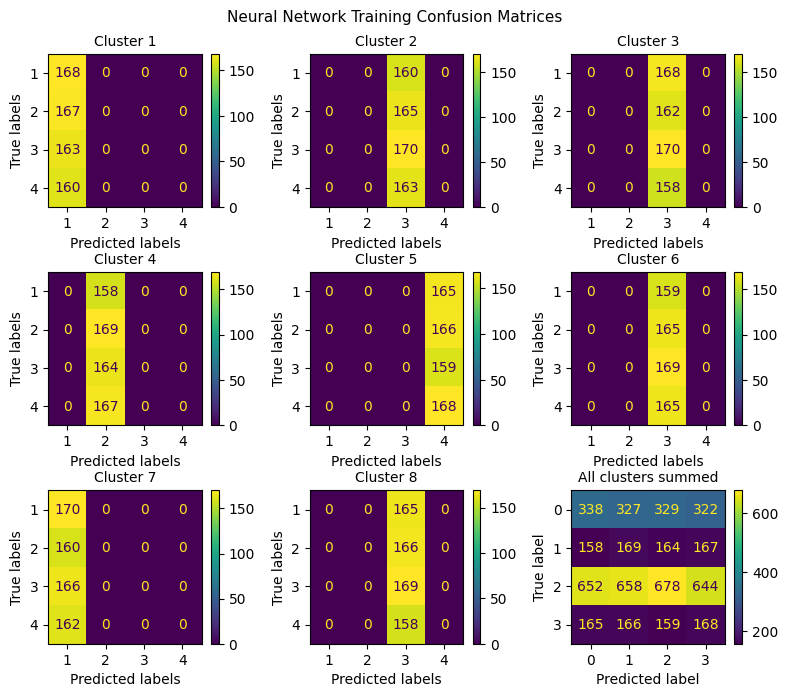

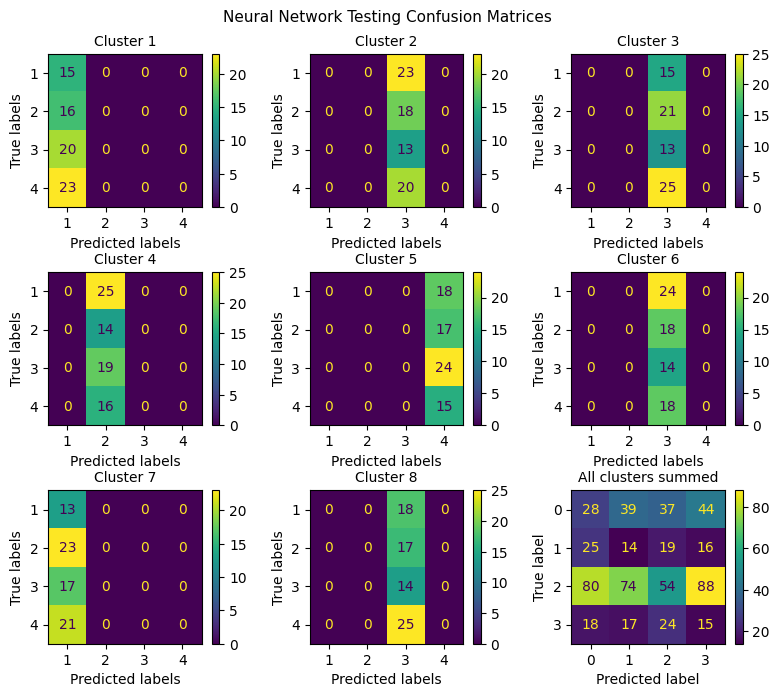

In [38]:
plot_confusion_matrices(nn_train_predictions_all_clusters,nn_train_labels_all_clusters,title="Neural Network Training Confusion Matrices")
plot_confusion_matrices(nn_test_predictions_all_clusters,nn_test_labels_all_clusters, title="Neural Network Testing Confusion Matrices")

### Plot Training and Validation Loss


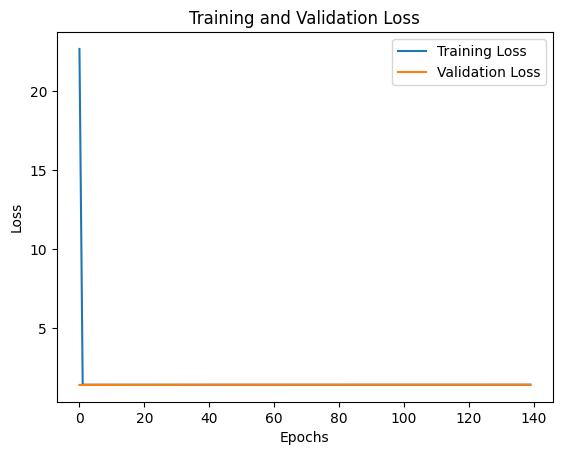

In [35]:
# Plot and label the training and validation loss values
plt.plot(losses[10:], label='Training Loss')
plt.plot(valid_losses[10:], label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Display the plot
plt.legend(loc='best')
plt.show()